In [50]:
!pip install networkx
!pip install fasttext
!pip install rouge

# File Imports

In [56]:
import os, io, re
import zipfile
import numpy as np, networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive
from oauth2client.client import GoogleCredentials

import fasttext
import pandas
from tqdm import tqdm
from rouge import Rouge

In [5]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/cs4501.zip"

Mounted at /content/drive
replace Stuff_to_share/debate2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Converting data from csv to txt

In [6]:
df = pandas.read_csv("Stuff_to_share/debateall.csv")
data = df["Full-Document"].to_numpy()
labels = df["Extract"].to_numpy()

In [7]:
data[0]

'German Chancellor Angela Merkel demanded on Thursday that the United States strike a "no-spying" agreement with Berlin and Paris by the end of the year, saying alleged espionage against two of Washington\'s closest EU allies had to be stopped.¶ Speaking after talks with EU leaders that were dominated by allegations that the U.S. National Security Agency had accessed tens of thousands of French phone records and monitored Merkel\'s private mobile phone, the chancellor said she wanted action from President Barack Obama, not just apologetic words.¶ Germany and France would seek a "mutual understanding" with the United States on cooperation between their intelligence agencies, and other EU member states could eventually take part.¶ "That means a framework for cooperation between the relevant (intelligence) services.Germany and France have taken the initiative and other member states will join," she said.¶ In a statement issued after the first day of the summit, the EU\'s 28 leaders said t

In [8]:
def writeToFile(writePath, arr):
    with open(writePath, "w") as f:
        f.write(" ".join(arr))

In [9]:
writeToFile("data.txt", data)
writeToFile("labels.txt", labels)

# Generating word embeddings via Skipgram

In [10]:
def Skipgram(fname = "data.txt", ws=3, dim=300):
    model = fasttext.train_unsupervised(fname, model="skipgram",ws=ws,dim=dim,neg=5)
    embeddings = model.get_output_matrix()

    #generate the vocabulary matrix
    vocabulary = {}
    words = model.get_words()
    for word in words:
        vocabulary[word] = model.get_word_id(word)
    
    # save model
    # model.save_model("debate2vec.bin")
        
    return embeddings, vocabulary

In [ ]:
# embeddings, vocabulary = Skipgram()
# print("Vocabulary :: \n", vocabulary)

# Loading Pre-Trained Word2Vec Model

In [11]:
def vocabDict(model):
    vocabulary = {}
    words = model.get_words()
    for word in words:
        vocabulary[word] = model.get_word_id(word)
    return vocabulary

In [12]:
model = fasttext.load_model("Stuff_to_share/debate2vec.bin")
embeddings = model.get_output_matrix()
vocabulary = vocabDict(model)

In [13]:
print("Vocabulary: ", vocabulary)
print(f"There are {len(vocabulary)} words in the vocabulary")

Vocabulary:  {'the': 0, 'of': 1, 'and': 2, 'to': 3, 'in': 4, 'a': 5, 'that': 6, 'is': 7, 'for': 8, 'as': 9, 'on': 10, 'it': 11, 'are': 12, 'with': 13, 'be': 14, 'by': 15, 'this': 16, 'not': 17, 'from': 18, 'have': 19, 'or': 20, 'has': 21, 'an': 22, 'but': 23, 'at': 24, 'its': 25, 'more': 26, 'their': 27, 'which': 28, 'they': 29, 'will': 30, 'we': 31, 'would': 32, 'states': 33, 'was': 34, 'u.s': 35, '</s>': 36, 'can': 37, 'other': 38, 'than': 39, 'these': 40, 'one': 41, 'also': 42, 'all': 43, 'such': 44, 'united': 45, 'been': 46, 'if': 47, 'about': 48, 'new': 49, 'there': 50, 'china': 51, 'who': 52, 'what': 53, 'he': 54, 'our': 55, 'us': 56, 'only': 57, 'world': 58, 'state': 59, 'political': 60, 'into': 61, 'economic': 62, 'could': 63, 'were': 64, 'some': 65, 'power': 66, 'no': 67, 'when': 68, 'even': 69, 'most': 70, 'said': 71, 'between': 72, 'his': 73, 'so': 74, 'may': 75, 'over': 76, 'people': 77, 'i': 78, 'security': 79, 'many': 80, 'because': 81, 'nuclear': 82, 'those': 83, 'global

# Cleaning and Tokenizing Text

In [14]:
nltk.download("stopwords")
nltk.download("punkt")
stop_words = nltk.corpus.stopwords.words("english")

def remove_stopwords(sent):
    return " ".join([word for word in sent if word not in stop_words])

def sanitize(sent):
    sent = sent.lower()
    return re.sub(r"[^a-zA-Z0-9\s]"," ", sent)

def make_ngrams(sent, n=2):
    sent = sanitize(sent)
    tokens = [token for token in word_tokenize(sent) if not token == ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
text = data[0]
article_tokenize = sent_tokenize(text)
clean_article = [sanitize(i) for i in article_tokenize]
clean_article = [remove_stopwords(s.split()) for s in clean_article]
print(article_tokenize)
print(clean_article)

['German Chancellor Angela Merkel demanded on Thursday that the United States strike a "no-spying" agreement with Berlin and Paris by the end of the year, saying alleged espionage against two of Washington\'s closest EU allies had to be stopped.¶ Speaking after talks with EU leaders that were dominated by allegations that the U.S. National Security Agency had accessed tens of thousands of French phone records and monitored Merkel\'s private mobile phone, the chancellor said she wanted action from President Barack Obama, not just apologetic words.¶ Germany and France would seek a "mutual understanding" with the United States on cooperation between their intelligence agencies, and other EU member states could eventually take part.¶ "That means a framework for cooperation between the relevant (intelligence) services.Germany and France have taken the initiative and other member states will join," she said.¶ In a statement issued after the first day of the summit, the EU\'s 28 leaders said 

In [20]:
def tokenize_sentences(d=data):
    ret_at = []
    ret_st = []
    for text in data:
        article_tokenize = sent_tokenize(text)
        clean_article = [sanitize(i) for i in article_tokenize]
        clean_article = [remove_stopwords(s.split()) for s in clean_article]
        ret_at.append(article_tokenize)
        ret_st.append(clean_article)
    return ret_at, ret_st

In [21]:
data_at, data_st = tokenize_sentences(data)
labels_at, labels_st = tokenize_sentences(labels)

# Calculating relevance of sentences within articles via cosine similarity

In [22]:
s = "This is a good idea"
t = "Horses eat apples"
cosine_similarity(model.get_sentence_vector(s).reshape(1,300), model.get_sentence_vector(t).reshape(1,300))

array([[0.3018138]], dtype=float32)

In [24]:
def create_cosine_sim_matrix(data_tokenized):
    n = len(data_tokenized)
    sim = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if i != j:
                x = model.get_sentence_vector(data_tokenized[i]).reshape(1,300)
                y = model.get_sentence_vector(data_tokenized[j]).reshape(1,300)
                sim[i][j] = cosine_similarity(x,y)
    return sim

def get_k_best_sentences(data_tokenized, matrix, k=3):
    graph = nx.from_numpy_matrix(matrix)
    scores = nx.pagerank(graph)
    ranked = sorted(((scores[i], i) for i,s in enumerate(data_tokenized)), reverse=True)

    k = min(k, len(data_tokenized))
    arranged = sorted(ranked[0:k], key=lambda x:x[1])
 
    return "\n".join([data_tokenized[x[1]] for x in arranged])

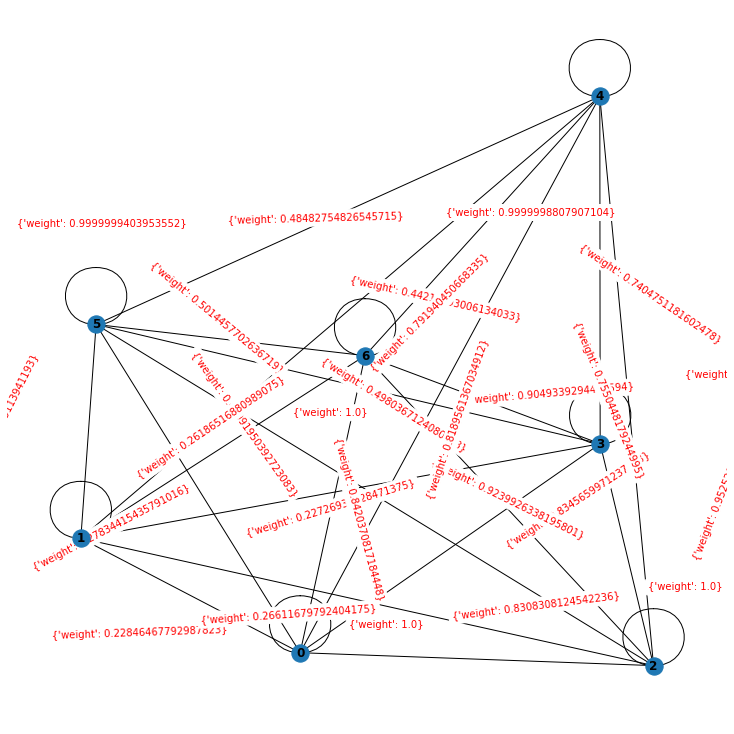

In [95]:
sim = create_cosine_sim_matrix(data_st[0])
summary = get_k_best_sentences(data_at[0], sim, 2)

graph = nx.from_numpy_array(sim)
plt.figure(figsize=(10,10))
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, font_weight="bold")
nx.draw_networkx_edge_labels(graph,pos,font_color="red")
plt.show()

In [97]:
print("Original Document: \n", "\n".join(data_at[0]), "\n\n Summary: \n", summary)

Original Document: 
 German Chancellor Angela Merkel demanded on Thursday that the United States strike a "no-spying" agreement with Berlin and Paris by the end of the year, saying alleged espionage against two of Washington's closest EU allies had to be stopped.¶ Speaking after talks with EU leaders that were dominated by allegations that the U.S. National Security Agency had accessed tens of thousands of French phone records and monitored Merkel's private mobile phone, the chancellor said she wanted action from President Barack Obama, not just apologetic words.¶ Germany and France would seek a "mutual understanding" with the United States on cooperation between their intelligence agencies, and other EU member states could eventually take part.¶ "That means a framework for cooperation between the relevant (intelligence) services.Germany and France have taken the initiative and other member states will join," she said.¶ In a statement issued after the first day of the summit, the EU's 

In [59]:
k = 2
all_sims = []
all_summaries = []

for i, d in tqdm(enumerate(data_st)):
    mat = create_cosine_sim_matrix(d)
    all_sims.append(mat)
    all_summaries.append(get_k_best_sentences(data_at[i], mat, k))

print(all_summaries[5])

187386


86it [00:56,  1.51it/s]


KeyboardInterrupt: ignored

# Evaluating our model using Rouge-N metrics

In [100]:
def calculate_rouge_2(hypotheses, references):
    p, r = [],[]

    for i in tqdm(range(len(hypotheses))):
        bigrams_sum = set(make_ngrams(hypotheses[i], n=2))
        bigrams_orig = set(make_ngrams("".join(references[i]), n=2))
        
        matches = bigrams_sum.intersection(bigrams_orig)
        #Recall
        recall = float(len(matches)/len(bigrams_orig))
        #Precision
        precision = float(len(matches)/len(bigrams_sum))
        p.append(precision)
        r.append(recall)
    return p,r

In [98]:
precision, recall = calculate_rouge_2(all_summaries, data_at)

0.5653104925053534 0.9962264150943396
